In [2]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

import gym
from gym.spaces import Discrete
import numpy as np
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.td_off_policy_agent import TDOffPolicyAgent
from source.utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
test_td_off_policy_agent passed!


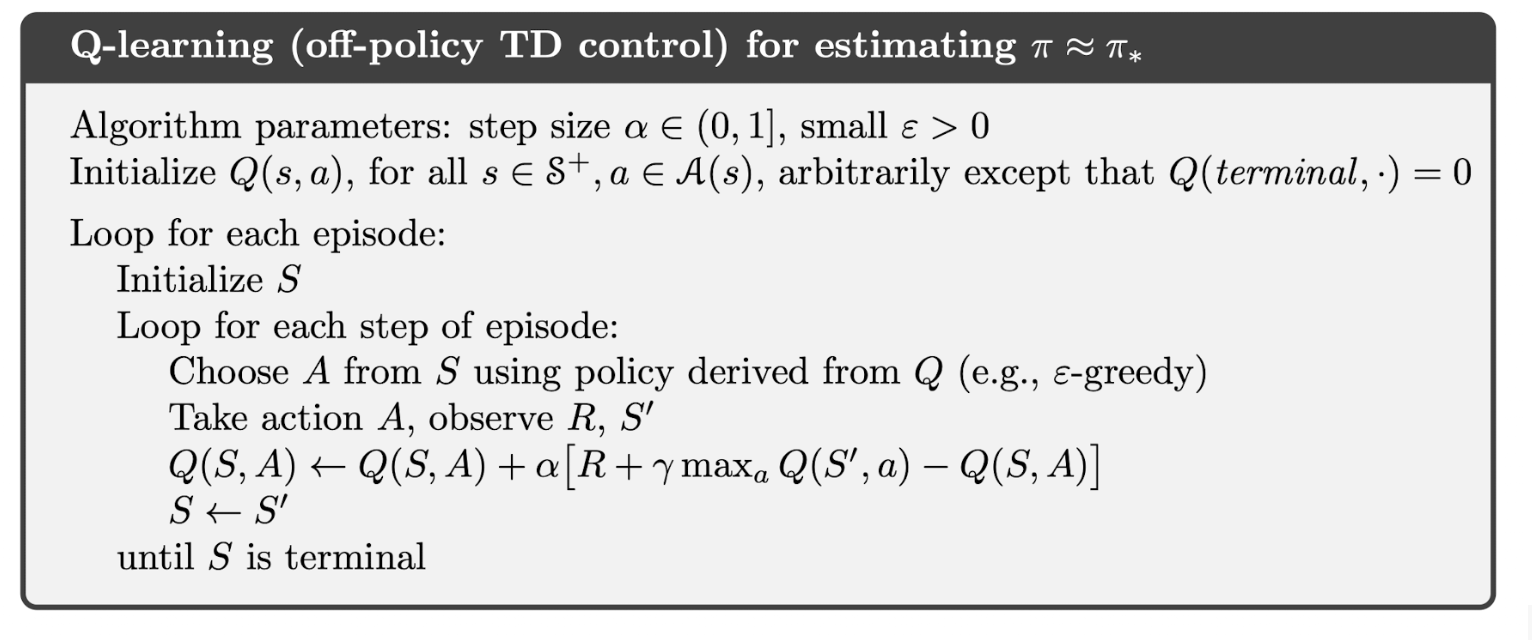

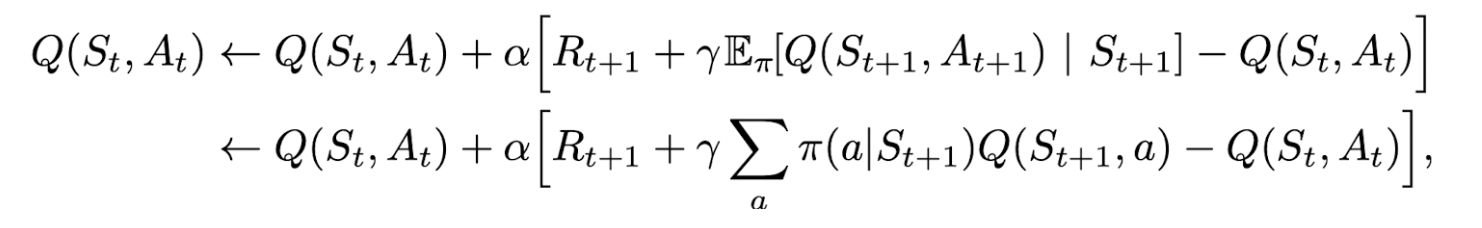

step: 1000, epsilon: 0.7247796636777333, total reward: 20.0, avarge success rate: 0.02, avarage reward per step: 0.0016165711917345903
step: 2000, epsilon: 0.5253055608808082, total reward: 51.0, avarge success rate: 0.031, avarage reward per step: 0.0023992775812471403
step: 3000, epsilon: 0.3807307877432351, total reward: 114.0, avarge success rate: 0.062, avarage reward per step: 0.004370225594236601
step: 4000, epsilon: 0.2759459322923004, total reward: 253.0, avarge success rate: 0.139, avarage reward per step: 0.008583734528468808
step: 5000, epsilon: 0.20000000000005203, total reward: 452.0, avarge success rate: 0.199, avarage reward per step: 0.010975437398063637
step: 6000, epsilon: 0.14495593273558435, total reward: 688.0, avarge success rate: 0.236, avarage reward per step: 0.012701502685045172
step: 7000, epsilon: 0.10506111217618895, total reward: 1025.0, avarge success rate: 0.337, avarage reward per step: 0.017455994503016683
step: 8000, epsilon: 0.07614615754866683, tot

100%|██████████| 10000/10000 [00:06<00:00, 1634.45it/s]


Success rate = 0.7724


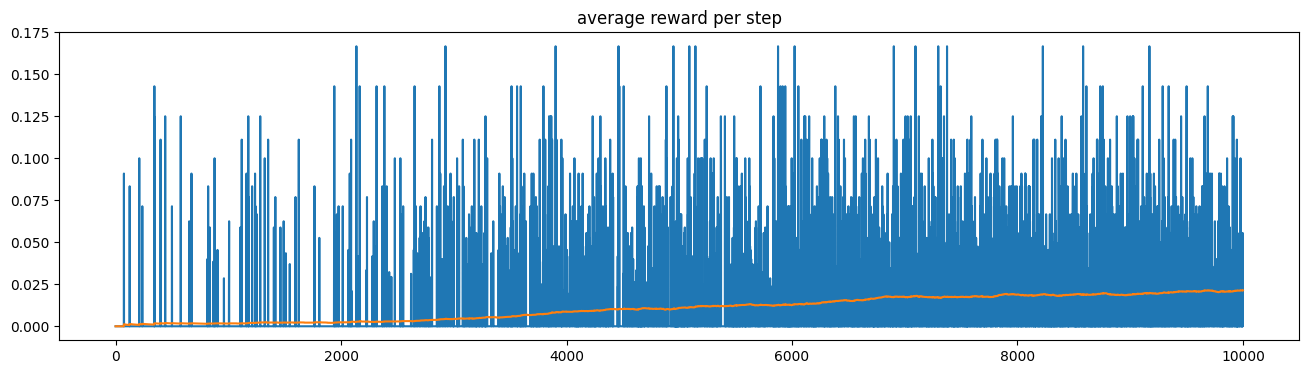

In [4]:
# Policy Eval
# Params
max_episode = 10000
video_path = os.path.join(ROOT, "video/td_off_policy.mp4")
random_seed = 101

# Initialize
history = []
total_reward = 0
report_interval = max_episode // 10
# set random seeds
rng = np.random.default_rng(random_seed)
np.random.seed(random_seed)
# epsilon decay
epsilon_schedule = create_decay_schedule(max_episode)
lr_schedule = create_decay_schedule(max_episode)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4",
               is_slippery=True, render_mode='rgb_array')
env.np_random = rng

# Create Agent
agent = TDOffPolicyAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    discount_rate=0.95,
    epsilon=1.0,
    learning_rate=0.1,
    agent_type='q_learning',
  )
# Start Learning
for i in range(max_episode):
    reward, steps = agent.play_episode(env, epsilon=epsilon_schedule[i])
    history.append(reward / steps)
    total_reward += reward
    if i % report_interval == 0 and i != 0:
        print(
            f"step: {i}, epsilon: {epsilon_schedule[i]}, total reward: {total_reward}, avarge success rate: {np.sum([x > 0 for x in history[-report_interval:-1]])/report_interval}, avarage reward per step: {np.mean(history[-report_interval:-1])}")
print(f"\nrewarding episodes: {total_reward}")

# For off policy learning only: get greedy policy (no exploration)
agent._policy = get_epsilon_greedy_policy_from_action_values(agent._Q)
# Run Eval
success_rate = estimate_success_rate(agent, env, 10000)
print(f"Success rate = {success_rate}")
# play last episode with video recording
#agent.play_episode(env, learning=False, video_path=video_path)

plot_history(history)
# html=render_mp4(video_path)
# HTML(html)


# Summary

## Tempro Difference Off-policy learning
The advantage of off policy learning is that the target policy is different from behavior policy. For TD:
1. Target policy is implicitly represented by action values `_Q`
2. Behavior policy is calcualted by applying epsilon greedy on action values `_Q`

The learned action-value function, `_Q`, directly approximates `q*`, the optimal action-value function, independent of the policy being followed. 

### Q-Learning
Q-learning use `R + max_a(Q(next_state, a)` to represent the future returns, which is independent of the policy being followed.

### Expected Sarsa
Q-learning use `R + E_a(Q(next_state, a)`(where `a` can follow any policy) to represent the future returns.



> Is Expected Sarsa considered off-policy?

> Expected SARSA can be used either on-policy or off-policy. The policy used in the update step determines which it is. If the update step uses a different weighting(target policy) for action choices than the policy that actually took the action(behavior policy), then you are using Expected SARSA in an off-policy way.

> Q-learning is a special case of Expected SARSA, where the target policy is greedy with respect to the action values, so there is only ever one 𝑟𝑡+1+𝛾max𝑎′𝑄(𝑠𝑡+1,𝑎′) term to add with a probability 1.

> link: https://ai.stackexchange.com/questions/20419/is-expected-sarsa-an-off-policy-or-on-policy-algorithm#:~:text=Expected%20SARSA%20can%20be%20used,in%20an%20off%2Dpolicy%20way. 



